# Scaletta

1. [x] *Come è il database*
2. [x] *Come sono distribuiti i terremoti (solo gil USA avevano i dati distribuiti "come ci aspettavamo", ovvero legge logatirmica, ...)*
3. [x] Aftershock-foreshock, processo epidemico, perché non possiamo girare i terremoti
4. [x] *Cluster k-mean (problema di analisi di scale tipiche a livello dei diversi cluster: per questo è stato scelto k-mean e non DBSCAN, con l'idea in partenza che fosse già qualcosa da rielaborare a mano) e bias induttivo con informaizoni sulle faglie statunitensi: approfondimento K-means e DBSCAN*
5. [x] *Trovare picchi per ogni cluster, algoritmo con finestre temporali*
6. [x] *Dividere i segmenti dei cluster in pezzi da 50 rilevazioni (scelta arbitraria: compromesso tra lunghezza effettiva delle time series da inserire nella NN (non troppo corte) e numero di serie ottenibili di quella dimensione (non volevamo troppe poche serie temporali) )*
7. [x] Presenza di serie crescenti e oscillanti/statiche
8. [x] La y (label) è la magnitudo del terremoto finale
9. [x] Tipi di predittori:
    1. LSTM con dense 1, keras
    2. MLPRegressor, sklearn
    3. NN with labels and sigmoid
    Testi di classificazione con random, estrarre gaussiane con media e std sui dati di training
10. [x] Perché i dati non bastano? I dati con terremoti "bassi" sono molti rispetto a quelli con terremoti "alti", quindi si "sacrifica" la capacità di fare predizioni **varie** perché diamo alla rete tanti dati "vuoti"; in un certo senso la rete fa solo statistica senza imparare la serie.
11. [x] Custom loss: pesare di più quando sbaglia i terremoti con elevata magnitudo e meno il resto $\rightarrow$ in questo modo la rete spara semplicemente più in alto senza migliorare le prestazioni.
12. [x] Idea griglia: time series molto difficile da inserire in una griglia (simil immagine, visto che ci sono vari esmepi di ML di NN su immagini) poiché si fa fatica a decidere la scala tipica temporale e spaziale; inoltre, alcuni eventi potrebbero inserirsi nelle stesse caselle, quindi grandi problemi su ulteriore divisione, approssimazione ulteriore, inserimento di 2 eventi nella stessa casella.
13. [x] Evitare overfitting: usare early **stopping** e **dropout**
14. [x] No GPU/dask perché dataset troppo piccolo $\rightarrow$ no vantaggi notevoli
15. [ ] Gaussian process $\rightarrow$ un approccio alternativo ed equivalente: problemi con la stima delle scale tipiche dei processi.

### Obiettivo:
Studiare time series e cercare di fare previsioni utilizzando una NN, o almeno capire qual è la capacità predittiva delle Neural Network (con architetture "semplici") per la previsione di serie temporali, in particolare di terremoti.

### Dati
Proposta di dati generati da simulazioni che seguono un processo epidemico di generazione di terremoti secondo leggi empiriche per cui se avviene un terremoto di grande magnitudo, esso, con una certa probabilità, è stato preceduto da terremoti di intensità crescente (fatto non del tutto verificato e ancora sotto studio poiché non varrebbe per tutti i terremoti ma solamente in alcune zone: infatti, solitamente i terremoti di intensità molto alta non presentano cosiddetti "foreshock", ma si presentano come eventi improvvisi); inoltre, tale terremoto si suppone che sia seguito da una serie di altri terremoti di intensità decrescente e ad una distranza che segue una certa distribuzione (ricavata da osservazioni empiriche).

I dati erano generati con numerosi aftershok secondo un algoritmo consegnatoci come una *black box*, di cui abbiamo imparato a modificare i parametri fondamentali in modo opportuno. Abbiamo provato a modificare l'algoritmo inserendo i _foreshock_ ma si faceva molta fatica ad inserirli in modo corretto a causa delle interazioni presenti nel processo di generazione degli eventi; per questo motivo abbiamo pensato di spotare alcuni _aftershock_ in modo simmetrico rispetto all'evento che li ha generati ed etichettandoli come _foreshock_ invece che come _aftershock_. Ci siamo presto resi conto però che questo approccio era destinato a fallire poiché il processo con il quale "riflettevamo" tali terremoti era casuale, quindi essi non seguivano nessuna legge precisa e sarebbero quindi stati solamente dei processi casuali che rischiavano di sabotare l'algoritmo di apprendimento poiché appunto erano solamente un'aggiunta di rumore.

#### Problema
I dati generati in questo modo hanno alcuni problemi:
1. potrebbero non essere rappresentativi dei processi reali, nel senso che non contengono vera informazione e quindi, anche se la rete riuscisse ad impararli, non è detto che essa sia applicabile a situazioni reali
2. sono poco efficienti, nel senso che si vuole studiare cosa accade "prima" di un grande terremoto (o evento in generale) mentre i dati generati con questo processo hanno una grande quantità di eventi successivi agli eventi che ci interessa predire e pochi prima di essi; anche a questo riguardo, essi sono poco utili per i nostri scopi.
3. Spiccano molto rispetto al fondo... Sono palesemente riconoscibili, cosa che nei dati reali non sempre è possibile.

### Cambio dati
Abbiamo quindi deciso di allenare la rete su dati reali, in particolare abbiamo deciso di utilizzare i dati dell'USGS riferiti all'area del Nordamerica per gli anni dal 1991 al 2019. Questa scelta è stata dettata dalla qualità dei dati raccolti: essi si presentano in buon accordo con la distribuzione attesa presente in letteratura. Inoltre, il territorio coperto dalla presa dati è abbastanza ampio (l'intero territorio degli USA) e c'è una faglia molto importante con terremoti di magnitudo rilevante (>4.5). I dati raccolti in altre aree geografiche, per contro, non presentano altrettanta omogeneità, al punto di non presentare la tipica distribuzione del numero di terremoti in funzione della loro magnitudo.

I dati utilizzati presentano informazioni su latitudine, longitudine, profondità, magnitudo, tempo (espresso in secondi a partire dal primo terremoto presente nella serie). Abbiamo deciso di rielaborare i dati nel seguente modo:
* tralasciare la profondità, che è stata ritenuta non informativa se messa al confronto con le altre indicazioni geografiche (la misurazione della profondità è latrice di un errore percentuale molto rilevante, a tal punto che possono essere presenti profondità negative);
* si è passati da un sistema di coordinate polari su una sfera ad un sistema di coordinate cartesiane su un piano, in modo da facilitare il raggruppamento dei dati su base geografica. Il metodo utilizzato è quello della trasformazione di Peters, the advantage of which is that it preserves the distances (and, as a consequence, the areas). Other alterantives (such as the Mercator projection) were deemed unfeasible for our scopes because they do not have this property.


### Decisione di raggruppamento e costruzione delle serie da somministrare alla NN
Una volta deciso con che dati lavorare, un punto importante è stato capire in che forma somministrare i dati alla NN e quali informazioni passare alla stessa.
Once the format of the data was set, we went on to decide how to feed them to the NN. This choice is of paramount inmportance, as it implicitly bounds the architecture of the NN itself.

The first idea was to divide the dataset into a grid of both space and time fixed windows, using previous tiles to predict events in next ones, but this idea was discarded because of the compromise between the size of the time windows, the spatial grid size and the quantity of events in each *tile*:
* using small spatial grid wuold lead us to make a more accurate prediction in terms of space, but also implies having less data in each *tile*, making the prediction very hard to do;
* using greater time resolution would lead us to have more data in each *tile*, but the predicitons in terms of time would become meaningless (it makes no sense to predict an earthquake within a 10 days window).
For these reasons we preferred to adopt the cluster grouping.

The first step was to group the data on a geographical basis: the whole time series (comprehensive of all the earthquakes, regardless of their location) has too big of jumps between events for it to be feasibly learned by any sensible NN. It was then deemed essential to include some form of inductive bias in our problem: namely, the spatial relationships between earthquakes, which are linked by them belonging to the same fault line. This essentially amounts to a clustering procedure. The first clustering method we decided to employ was DBSCAN, a density based algorithm which previously showed nice properties: it need not to know the number of clusters in advance, nor is it sensitive to outliers. However, it needs to be fed a scale parameter and a minimum size. The performance of DBSCAN was not as good as expected: the problem lies in its dependance on the scale parameter: the data is not homogeneously distributed (not spatially nor temporally), so a density based approach can not reflect the local properties of the dataset: different areas have different tipical scales.

For these reasons, we gave up on DBSCAN, and turned to a more naive approach. We used k-means algorithm with a number of clusters that was in slight excess of the one we expected from an eye based analysis. The resulting clusters were then grouped together on the basis of their belonging to some specific (and well documented) fault lines. This hybrid procedure, while it may seem a bit too rough and a bit arbitrary, is indeed just a way of **introducing some inductive bias** in our data. This makes the hypothesis class of any statistical learning algorithm much more scoped, improving performance and reducing the amount of data needed in order to learn.

Once the fault line clustering was done, we decided to consider each of the clusters as a separate entity. As a result, each cluster contains a time series. In order to retrieve the mainshocks of each cluster, we used a peak-finding algorithm, the likes of those employed in signal processing: given a set of "time windows", it retrieves the maximum inside the window, ignoring any other peak, and then slides the window forward: this kind of procedure was decided in order not to have too short time series (if 2 events above the threshold were near, they would generate 2 time series, the second being very short; as a consequence, this second time series would be not usable to feed the NN).

As a last passage, we decided to split each cluster-time series on the basis of these maxima, grouping all previous events down to the the previous maximum, and then split each of these groups once again in chunks of 50 samples, since we needed an homogenous format for our data. The choice of 50 as the size of our snippets is the result of a compromise between the meaningfullness of each snippet and their number: a small size would result in many snippets with low information quantity, while a larger size would end up in too few snippets, despite their informativeness. The result of this procedure was a set of snippets of 50 samples each, the majority of which ended with a small or otherwise unremarkable earthquake, while a fraction ended with what was regarded as a mainshock. Consequently, the series belong to roughly 2 main types:
* *background series*, which represent the majority of them, in which there are no significant events;
* *mainshock series*, in which the last event is the mainshock looked for, which we hope the algorithm can learn.


### NN architecures and data formatting
Three main approaches were attempted:

* ###### A predicting NN with an LSTM layer:
    The purpose of an LSTM layer is to correlate data on the basis of their time ordering. In our case, however, proper time ordering was discarded, in the sense that we did not take proper times into account, but just the order of the events (induced by the proper time ordering). The LSTM layer was followed by a simple set of dense layers and a 'relu' layer as output.
    The porpouse of this NN was that of trying to predict the magnitude of the immediately successive earthquake (namely, the 50-th one) basing on the previous 49.
        
* ###### A logistic classifier NN with an LSTM layer:
    This NN was much similar to the previous one: its architecture also involved a LSTM layer, but as output this NN has a sigmoid layer that gives a result that can be interpret as the probability of the label to be 1. Its porpouse was to give a probability estimation of the fact that the series in exam is leading to a big magnitude earthquake (as classified by the peak-findind algorithm).
    
* ###### An MLP regressor, using sklearn implementation:
    `sklearn` has an MLP regressor implementation, which we first used on the same snippets. Being a regressor, the MLP should be able to predict the next sample, given each of the 50-size snippets as a training point.

The label passed to the algorithms to make estimations/classifications were of 2 kinds:
* for regression (predicting NN and MLP regressor) we used for the series the magnitude of the last earthquake as label, regardless of it being "low magnitude" (in the case of *backgroud series*) or "high magnitude" (in the case the snippets ended with a mainshock);
* for the classification, we simply put label 0 to background snippets and 1 to snippets that contained mainshocks.

All the NN implemented by means of Keras included some `dropout` layers: these are special layers that implement the dropout procedure, a common way of avoiding overfitting in deep learning. It basically consists in 'powering off' random neurons at each training step. Dropout layers can also be used in order to output estimates of variance together with the estimate of the mean prediction.

Another important feature of our Keras models is the use of an early stopping criterion: this consists in using some control quantity as a metric of the generalisation properties of our algorithm. For instance, by taking the performance of the NN on a validation set (different from both the training set and the test set) as a control quantity, the early stopping procedure allows us to stop the training as soon as the loss on the validation set stops decreasing and plateaus. Indeed, evaluating performance only on training set leads to almost certain overfitting.

After having a look at the first results, we decided to try to implement a **custom loss** to see whether the NNs can weight false negatives more than false positives; this way we expected the NNs to predict better, but the results remained poor. In particular, while the average predicted magnitude increased appreciably, it was more of a baseline addition than a real improvement in predictive accuracy.

### Results
The results of all architectures were very poor. The explanations to this can be many:
* the data can be really non-informative; we are supposing that we are able to predict earthquakes basing on the past history in the considered zone, but they can be correlated in a very complex way that we are not able to catch with our simple models.
* our models are too simple; our architectures are very simple and built with a small number of layers and neurons, which can be a major factor in poor predicting power. However, it should be noted that larger architecture wuold be more data hungry: the data at our disposal is too few to suffice those needs.
* as already mentioned, the analyzed time series can be grouped in roughly 2 main calsses:
    * *bkg series*
    * *mainshock series*
    we think the algorithm fails at predicting also because there are too few *mainshock series* to learn compared with the large number of background series. The result of this unbalance is that the NNs tend to learn data distribution instead of data trend with respect to time, even if there is the LSTM layer. One may think that pruning the dataset the algoritm can learn better, however throwing data away should not be considered a good option because, as already mentioned, NN are data hungry.





### Comments
* we decided not to use any kind of parallelization scheme because the ratio between costs in terms of time and effort and the increment in performance was disadvantageous. Indeed:
    * using GPUs would need a more sophisticated way to write the code, in addition to installing all drivers and stuff needed to work with them;
    * using "dask" to run parallel implementation was also considered, but the idea was scrapped because of the amount of data we were dealing with did not justify the additional heading that comes with a dask implementation; the resulting code might have been slower than the present one.
* the spatial data was then converted to differential form: the $x$ and $y$ information were converted into distances; the times, instead, were converted into days, in order to make their absolute values smaller (as an aid to the NN)




# Starting code

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime # USED IN THE COMMENTED CELL
from math import sin, cos, sqrt, pi, exp
from mpl_toolkits.mplot3d import Axes3D #3d plotting functions
import sklearn.cluster as skcluster
from scipy.signal import find_peaks, peak_prominences
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import model_from_json # to import saved models

# import NN stuff and training stuff
from sklearn.model_selection import train_test_split

import sklearn.neural_network as nn

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import Embedding
from keras.layers import LSTM
from keras.utils import plot_model

from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


# Simiulated data

In [2]:
#d=np.loadtxt("DATA/catalog_fore_seed200__mmin2.00_bg2.0000__b1.08_a0.90K0.2100_p1.10.dat", delimiter='\t')

# POSSIBLE FILE NAMES
#catalog_fore_seed200__mmin2.00_bg2.0000__b1.08_a0.90K0.2100_p1.10
#catalog_fore_seed201__mmin2.00_bg2.0000__b1.08_a0.90K0.2100_p1.10
#catalog_fore_seed202__mmin2.00_bg2.0000__b1.08_a0.90K0.2100_p1.10
#catalog_fore_seed203__mmin2.00_bg2.0000__b1.08_a0.90K0.2100_p1.10
#catalog_fore_seed204__mmin2.00_bg2.0000__b1.08_a0.90K0.2100_p1.10
#catalog_fore_seed205__mmin2.00_bg2.0000__b1.08_a0.90K0.2100_p1.10

file_name = "catalog_fore_seed205__mmin2.00_bg2.0000__b1.08_a0.90K0.2100_p1.10"
d = pd.read_csv(str("2019_earthquakes/EQQ/EQ_repo/" + str(file_name) + ".csv"), delimiter=';', header=0)
d = d.drop(columns=["Unnamed: 0"])
# d

In [3]:
d.columns = ["Time", "x", "y", "Magn", "i", "i_padre", "n_after", "n_after_cut", "labels"]
d["Label"] = pd.Series(np.zeros(len(d.values), dtype = int), index=d.index)
# d

## Turning data to "create" foreshoks

In [4]:
prob = 0.01
d_test = np.array(d.values)   # using np array

# starting to iterate over elements
for row in d_test:
    if (row[5] != -1):  # picking no BG events
        row[8] = 1      # conventional label to indicate BG
        # selecting with probability and with magnitude (row[3] selects the magnitude)
        #  d_test[:,4]                         is the colomn of indexes
        #  d_test[:,4] == row[5]               check the mother index
        #  d_test[d_test[:,4] == row[5]]       get the mother row
        #  d_test[d_test[:,4] == row[5]][:,3]  get the mother magnitude
        
        if ( (np.random.rand() < prob) and (row[3] < (d_test[d_test[:,4] == row[5]][:,3]) ) ):
            #if (row[0] > 2 * d_test[d_test[:,4] == row[5]][0] - row[0]):
            row[0] = 2 * d_test[d_test[:,4] == row[5]][:,0] - row[0]
            row[8] = 2

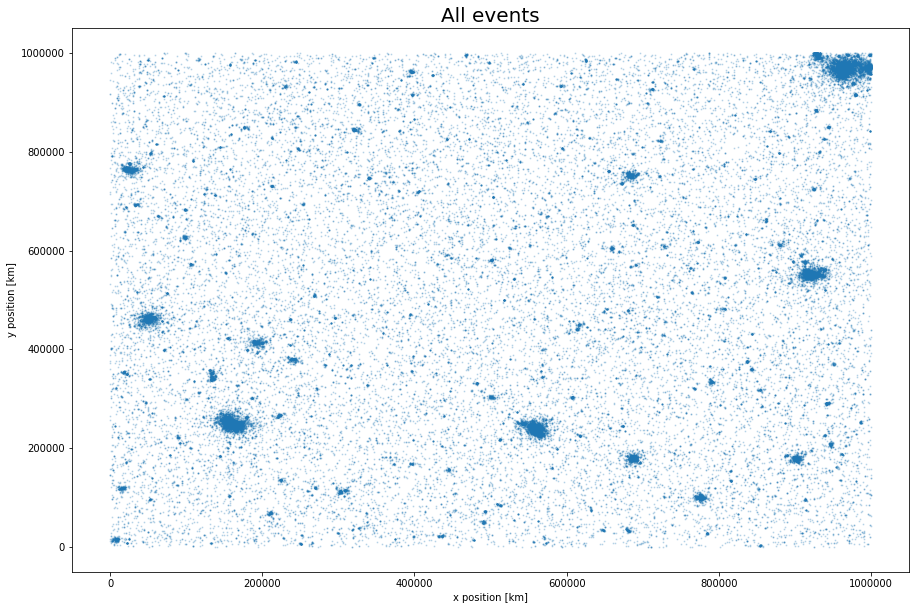

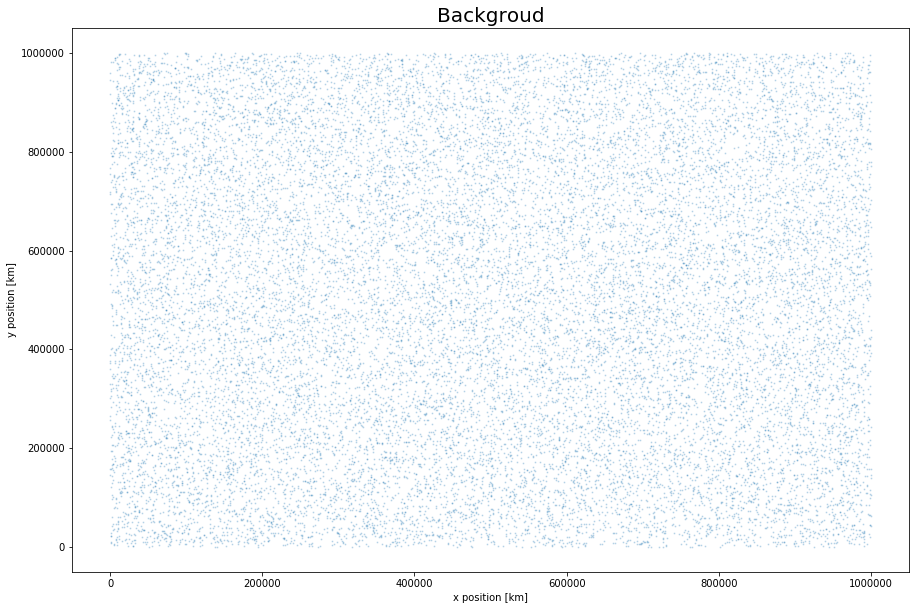

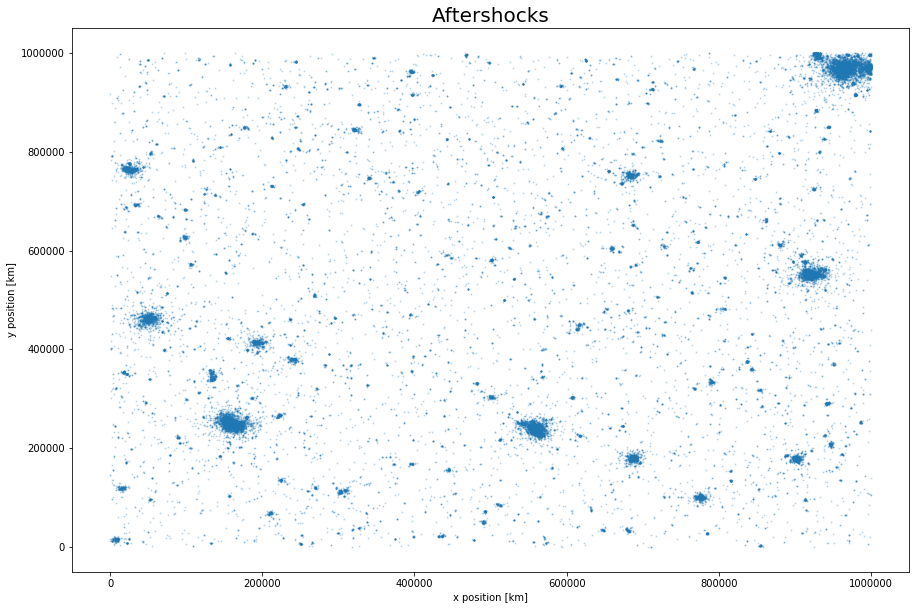

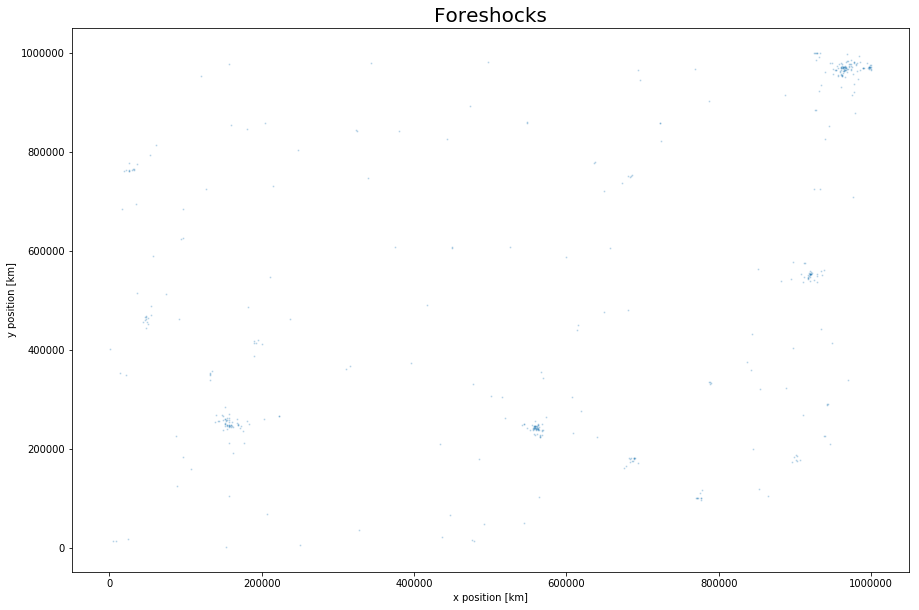

In [5]:
# plotting everything
plt.figure(figsize=(15, 10))
plt.title("All events", fontsize=20)
plt.xlabel("x position [km]")
plt.ylabel("y position [km]")
plt.scatter(d_test[:,1], d_test[:,2], s=1, alpha=0.2)
plt.show()

# plotting bg
plt.figure(figsize=(15, 10))
plt.title("Backgroud", fontsize=20)
plt.xlabel("x position [km]")
plt.ylabel("y position [km]")
plt.scatter(d_test[d_test[:,8] == 0][:,1], d_test[d_test[:,8] == 0][:,2], s=1, alpha=0.2)
plt.show()

# plotting aftershock
plt.figure(figsize=(15, 10))
plt.title("Aftershocks", fontsize=20)
plt.xlabel("x position [km]")
plt.ylabel("y position [km]")
plt.scatter(d_test[d_test[:,8] == 1][:,1], d_test[d_test[:,8] == 1][:,2], s=1, alpha=0.2)
plt.show()

# plotting foreshocks
plt.figure(figsize=(15, 10))
plt.title("Foreshocks", fontsize=20)
plt.xlabel("x position [km]")
plt.ylabel("y position [km]")
plt.scatter(d_test[d_test[:,8] == 2][:,1], d_test[d_test[:,8] == 2][:,2], s=1, alpha=0.2)
plt.show()

In [6]:
d_sorting = d_test.T.copy()

#print(d_sorting[0])

print("Negative times:",len(d_sorting[0][d_sorting[0]<0]))

for i in range(len(d_sorting)):
    d_sorting[i] = d_sorting[i][np.argsort(d_sorting[0])]

mask = np.arange(len(d_sorting[0]))
mask[d_sorting[0]>=0] = 0
#print(mask)
d_new = np.delete(d_sorting, mask, axis=1)
print("Length of cut data:", len(d_new[0]))
print("Length of uncut data:", len(d_sorting[0]))
print("Chechinkg difference:", len(d_new[0]) - len(d_sorting[0]))

mask = np.arange(len(d_test[:,0]))
mask[d_test[:,0] > 0] = -1
mask = mask[mask!=-1]
d_new1 = np.delete(d_test, mask, axis=0)
#print(len(d_new1))

Negative times: 21
Length of cut data: 73212
Length of uncut data: 73233
Chechinkg difference: -21


In [7]:
d_new.shape

(10, 73212)

### Modifying the data in order to have a more manageable dataset

In [8]:
data = np.array([d_new[1,:], d_new[2,:], d_new[0,:]]).T
data.shape

(73212, 3)

### Trying DBSCAN

In [19]:
res = skcluster.DBSCAN(eps=10000, min_samples=100, metric='euclidean', leaf_size=30).fit(data)
predictions = res.fit_predict(data)

In [20]:
print(np.unique(predictions))
print("Len predictions", len(predictions))
print(res.components_)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32]
Len predictions 73212
[[5.53370000e+05 2.51459000e+05 5.95552062e+01]
 [9.85688000e+05 9.48366000e+05 1.20492941e+02]
 [1.54671000e+05 2.35052000e+05 2.05438966e+02]
 ...
 [1.95890000e+05 4.11889000e+05 1.09498088e+04]
 [9.46630000e+05 2.05495000e+05 1.09514407e+04]
 [9.19342000e+05 5.50911000e+05 1.09556600e+04]]


In [21]:
magn = d_new[3,:]
magn = magn.reshape(len(magn),1)
magn.shape

(73212, 1)

In [22]:
data_work = np.array([d_new[1,:], d_new[2,:], d_new[3,:]]).T
data_work

array([[4.82180e+05, 5.32492e+05, 2.30000e+00],
       [4.15360e+05, 9.24182e+05, 2.07000e+00],
       [9.28175e+05, 8.72969e+05, 2.09000e+00],
       ...,
       [9.19342e+05, 5.50911e+05, 2.17000e+00],
       [1.79692e+05, 3.99212e+05, 2.14000e+00],
       [8.62025e+05, 9.33054e+05, 3.30000e+00]])

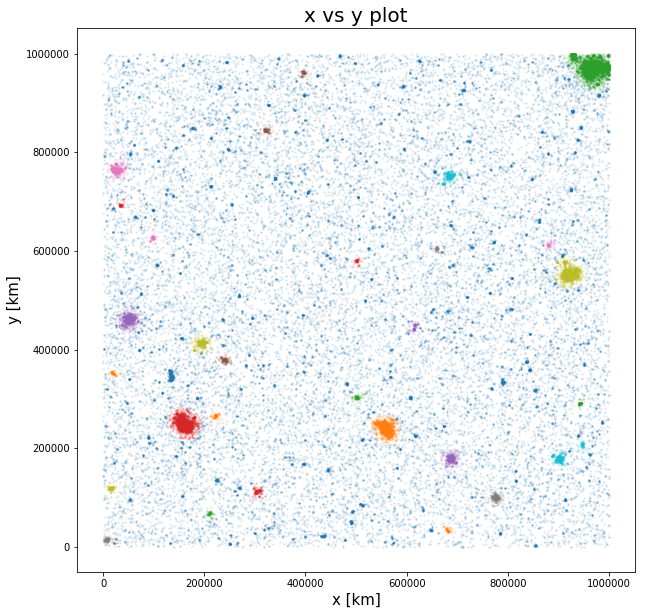

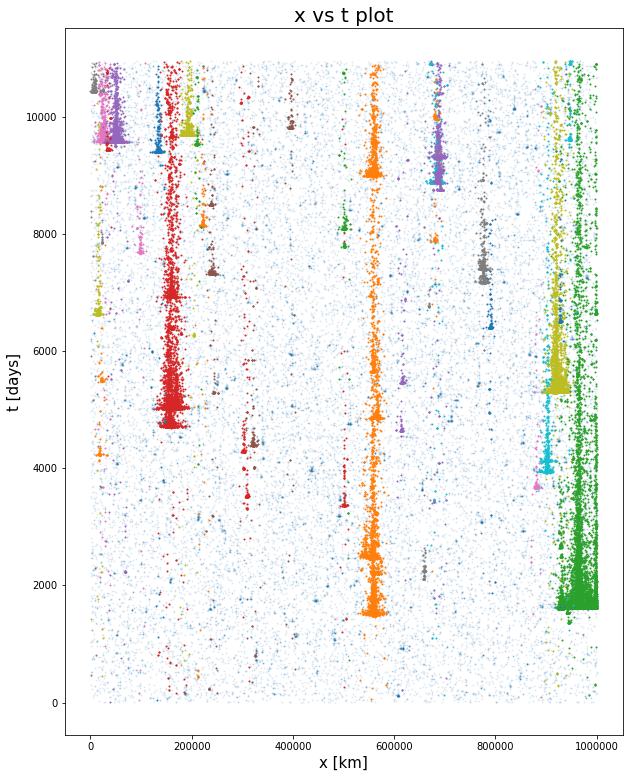

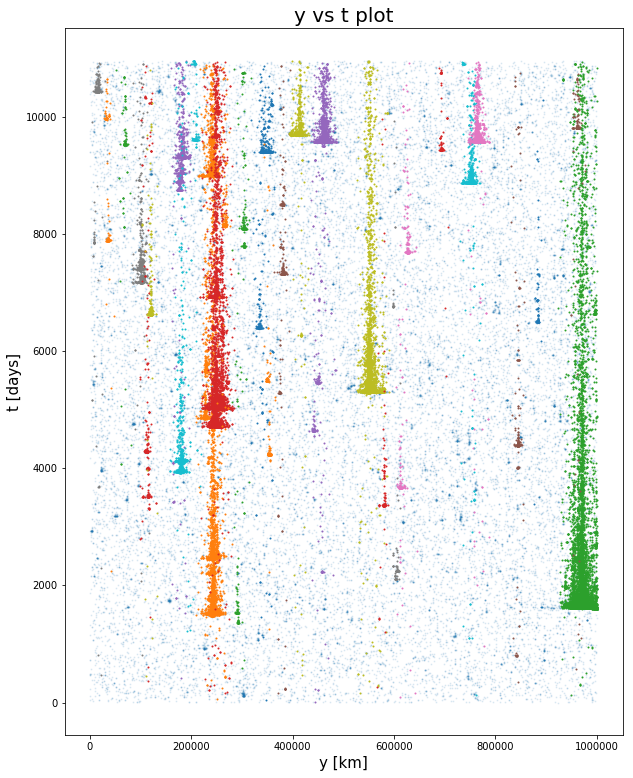

In [23]:
%matplotlib inline

# plotting space
plt.figure(figsize=(10,10))

plt.scatter(data[np.where(predictions==-1), 0], data[np.where(predictions==-1), 1], alpha=0.1, s=2)

for i in np.unique(predictions)[1:]:
    plt.scatter(data[np.where(predictions==i), 0], data[np.where(predictions==i), 1], alpha=0.1, s=2)

plt.title("x vs y plot", fontsize=20)
plt.xlabel("x [km]", fontsize=15)
plt.ylabel("y [km]", fontsize=15)
plt.show()


# pltting time
plt.figure(figsize=(10,13))

plt.scatter(data[np.where(predictions==-1), 0], data[np.where(predictions==-1), 2], alpha=0.1, s=1)

for i in np.unique(predictions)[1:]:
    plt.scatter(data[np.where(predictions==i), 0], data[np.where(predictions==i), 2], alpha=1, s=1)

plt.title("x vs t plot", fontsize=20)
plt.xlabel("x [km]", fontsize=15)
plt.ylabel("t [days]", fontsize=15)
plt.show()


plt.figure(figsize=(10,13))

plt.scatter(data[np.where(predictions==-1), 1], data[np.where(predictions==-1), 2], alpha=0.1, s=1)

for i in np.unique(predictions)[1:]:
    plt.scatter(data[np.where(predictions==i), 1], data[np.where(predictions==i), 2], alpha=1, s=1)

plt.title("y vs t plot", fontsize=20)
plt.xlabel("y [km]", fontsize=15)
plt.ylabel("t [days]", fontsize=15)
plt.show()

# True data (USA data)

In [24]:
df1=pd.read_csv("USA_prepared_1991_2005.csv")
df2=pd.read_csv("USA_prepared_2005_2019.csv")
df2['time']=df2['time']+np.array(df1['time'])[-1]
df=pd.concat([df1, df2],ignore_index=True)
#df

### Plotting magnitude time series of the whole USA dataset (only to have a look, not really useful)

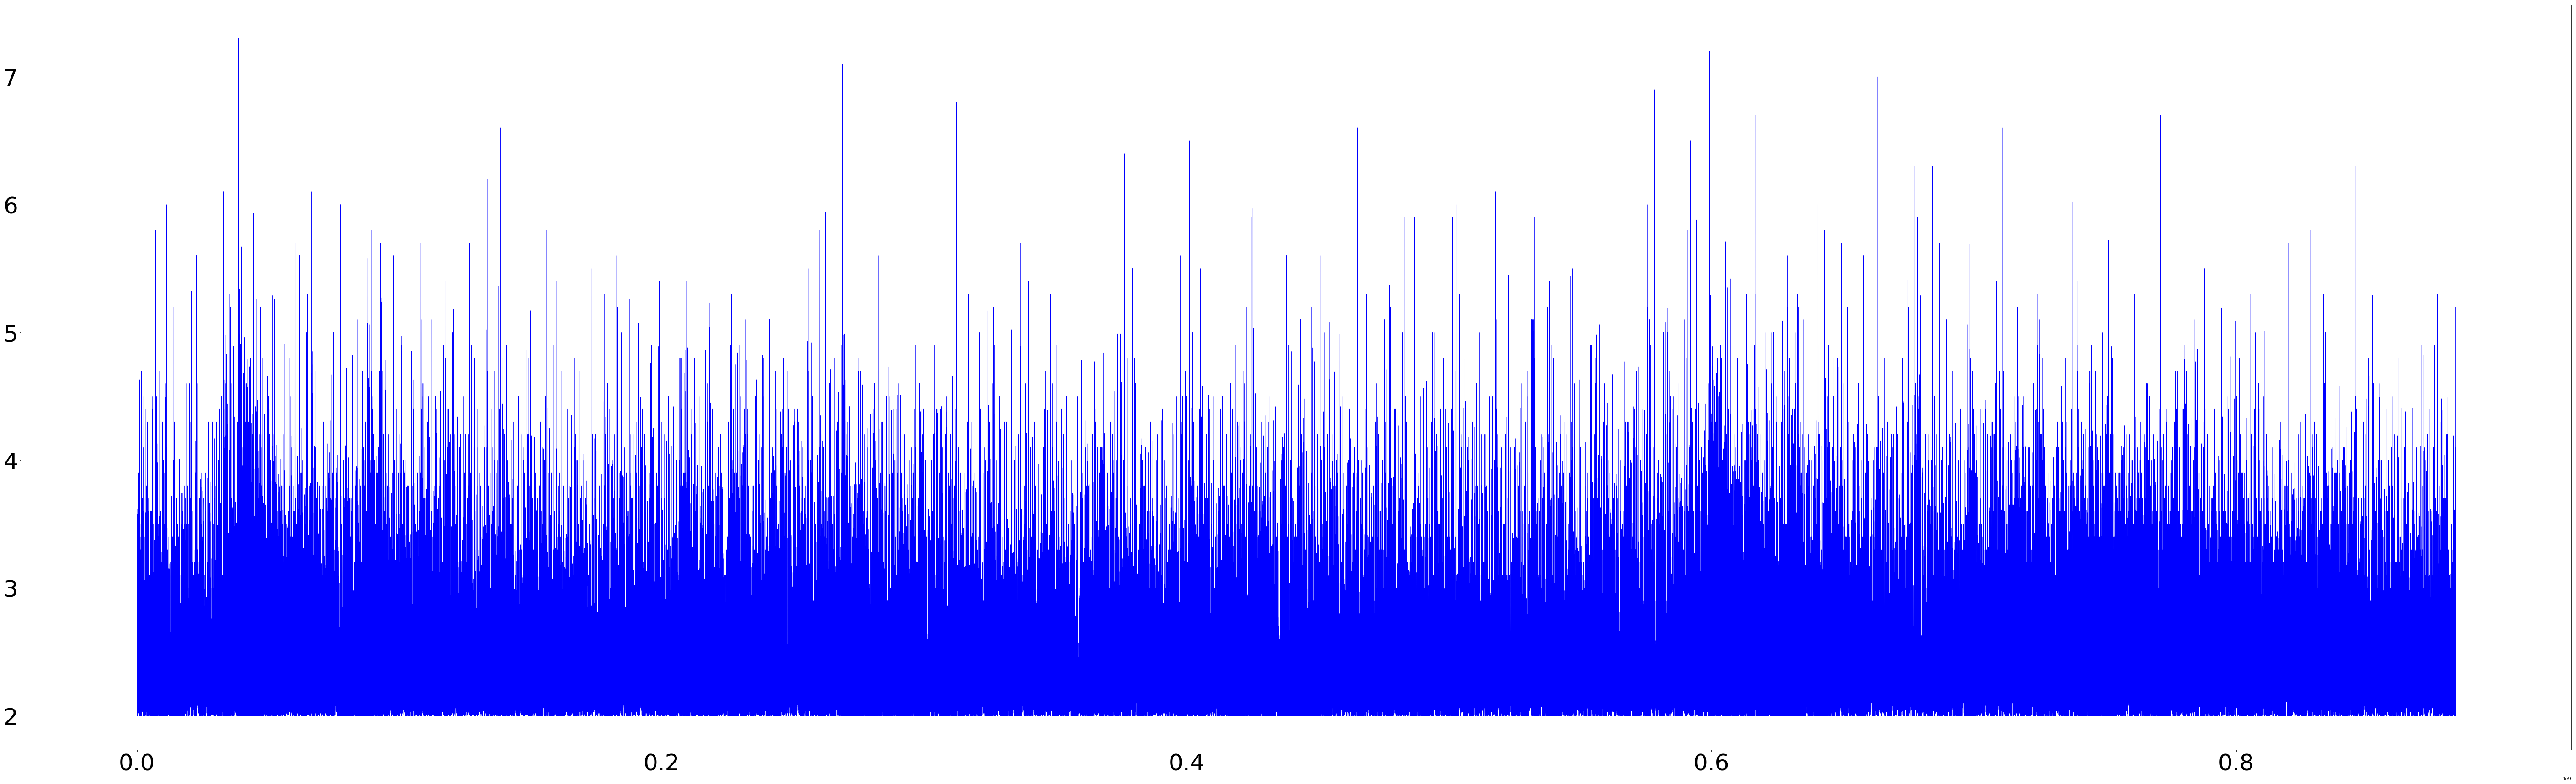

In [25]:
# plotting the time series of magnitudes
plt.figure(figsize=(100,30))
plt.plot(np.array(df)[:,0], np.array(df)[:,4], lw=1, c="#0000aa")
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.show()

## Flattening data onto a plane

In [26]:
df['x']=df['longitude']*np.pi*6371/(180*np.sqrt(2)) # it's in km
df['y']=np.sin(df['latitude']*2*np.pi/360)*6371*np.sqrt(2)

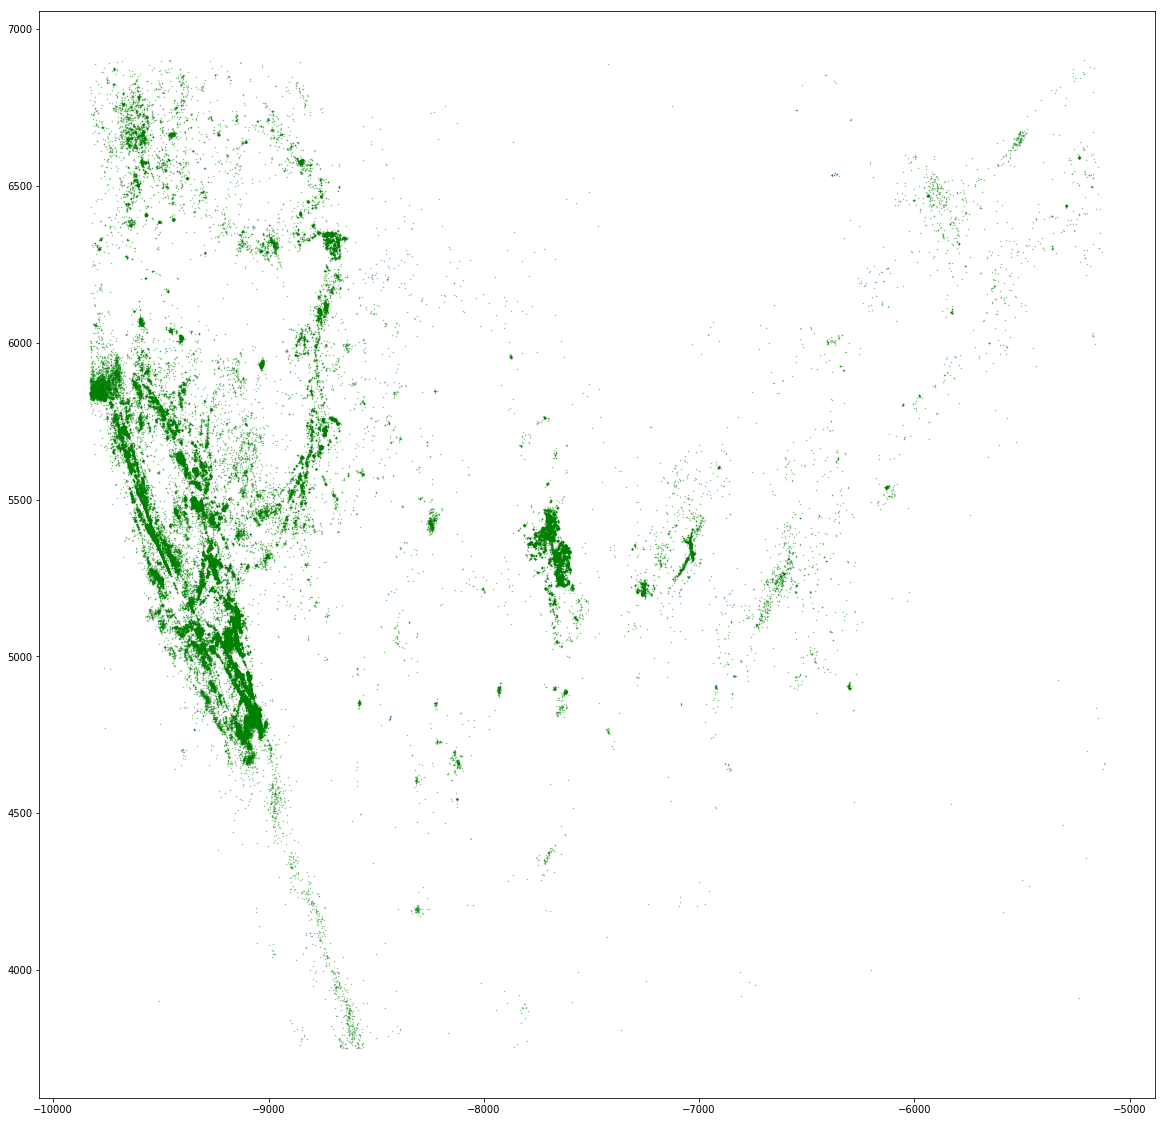

In [27]:
plt.figure(figsize=(20,20))
plt.scatter(np.array(df)[:,5],np.array(df)[:,6],s=0.2, alpha=0.5, c="Green")
plt.show()

In [28]:
plane_USA = np.array([df["x"], df['y']]).T
plane_USA

array([[-9341.49249623,  5482.35496163],
       [-9813.18708874,  5839.55085079],
       [-9822.0850114 ,  5840.40903535],
       ...,
       [-9253.18162004,  5304.54452424],
       [-8860.04818672,  6293.66534038],
       [-9530.60277687,  5372.88481234]])

### Trying DBSCAN (N.B.: THE AMOUNT OF DATA REQUIRES A VERY PERFORMING COMPUTER WITH A VERY LARGE RAM: PLEASE BE CAREFUL RUNNING FOLLOWING CELLS)

In [29]:
#res = skcluster.DBSCAN(eps=500, min_samples=50, metric='euclidean', leaf_size=30).fit(plane_USA)
#predictions = res.fit_predict(plane_USA)

#print(np.unique(predictions))
#print(len(predictions))
#print(res.components_)

In [30]:
#fig = plt.figure(figsize=(12, 12))

#plt.scatter(plane_USA[np.where(predictions==-1), 0], plane_USA[np.where(predictions==-1), 1], s=1, c="k", alpha=0.25)

#for i in np.unique(predictions)[1:]:
#    plt.scatter(plane_USA[np.where(predictions==i), 0], plane_USA[np.where(predictions==i), 1], alpha=0.1, s=2)

#plt.show()

### Loading a DBSCAN ran on a smaller dataset to show the difficulties of the algorithm

<img src="Fail_DBSCAN.png">

## Discarding DBSCAN in favour of naive grouping helped by K-mean clustering

In [31]:
# setting seed to make work re-doable in the same way
res = skcluster.KMeans(n_clusters=10, random_state=123).fit(plane_USA)
predictions_K = res.fit_predict(plane_USA)

print(np.unique(predictions_K))
print(predictions_K)

[0 1 2 3 4 5 6 7 8 9]
[8 0 0 ... 8 3 8]


### Plotting

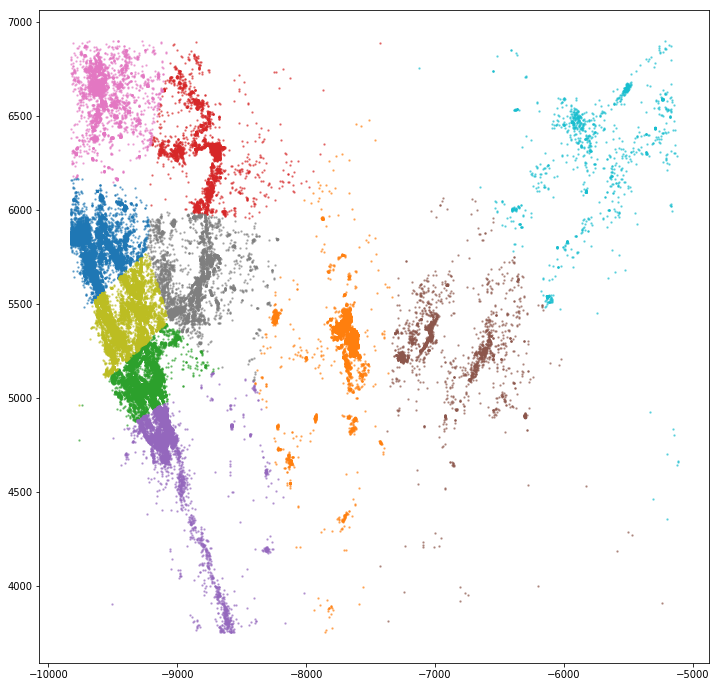

In [32]:
fig = plt.figure(figsize=(12, 12))

#plt.scatter(plane_USA[np.where(predictions_K==-1), 0], plane_USA[np.where(predictions_K==-1), 1], s=1, c="k", alpha=0.25)

for i in np.unique(predictions_K):
    plt.scatter(plane_USA[np.where(predictions_K==i), 0], plane_USA[np.where(predictions_K==i), 1], alpha=0.5, s=2)
plt.show()

<Figure size 576x576 with 0 Axes>

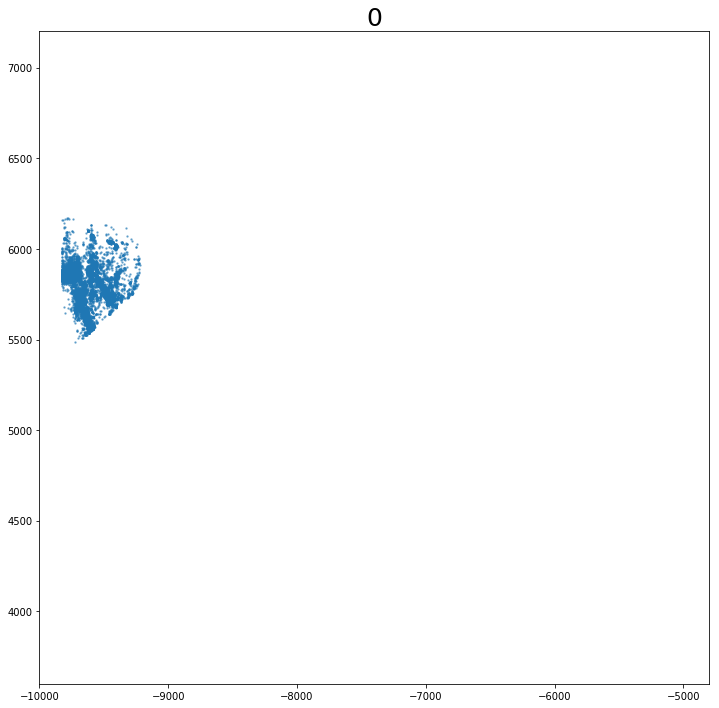

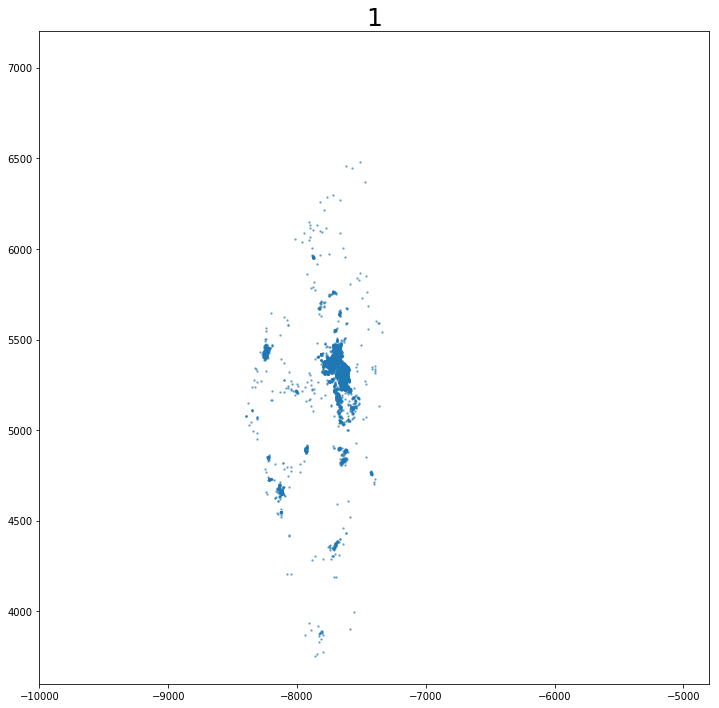

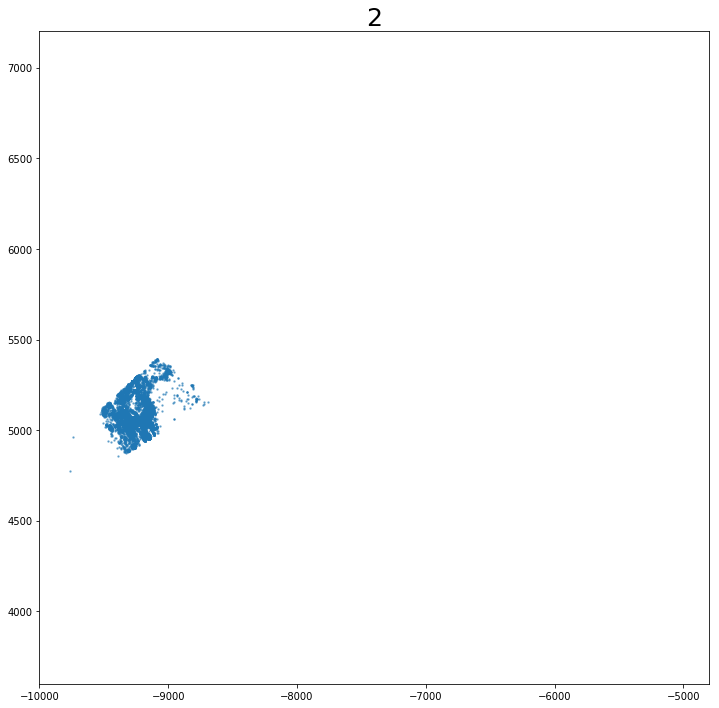

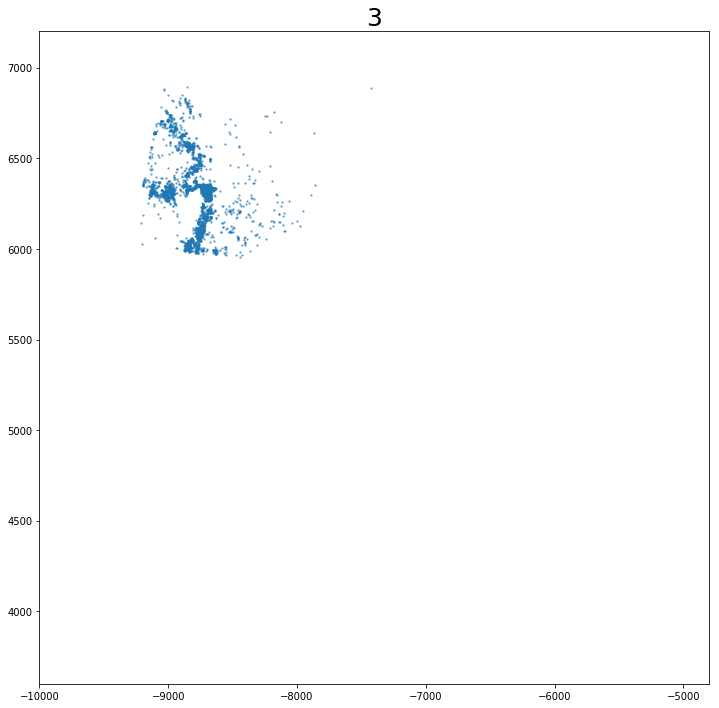

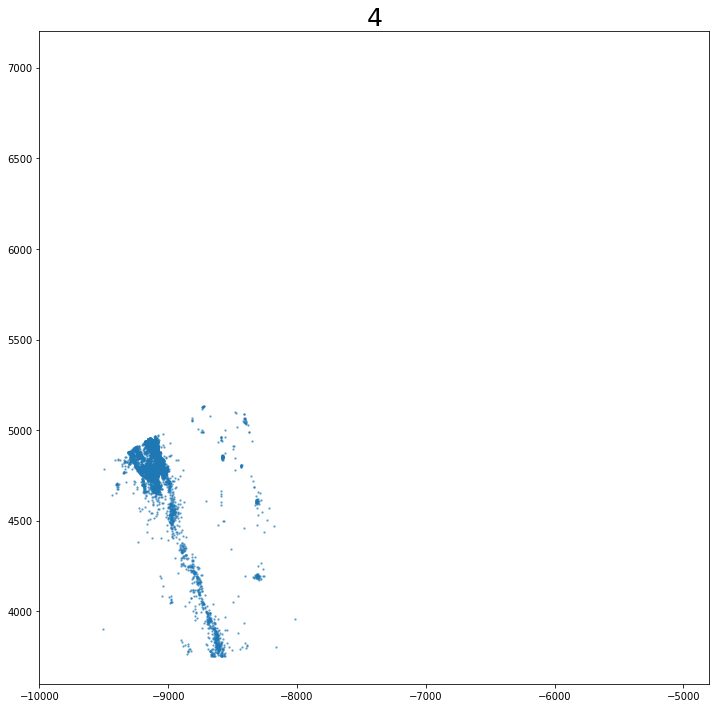

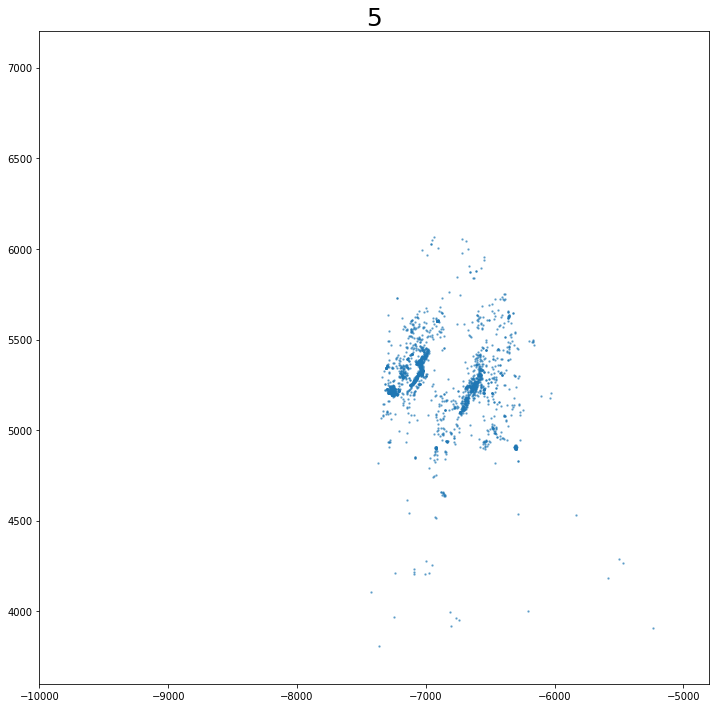

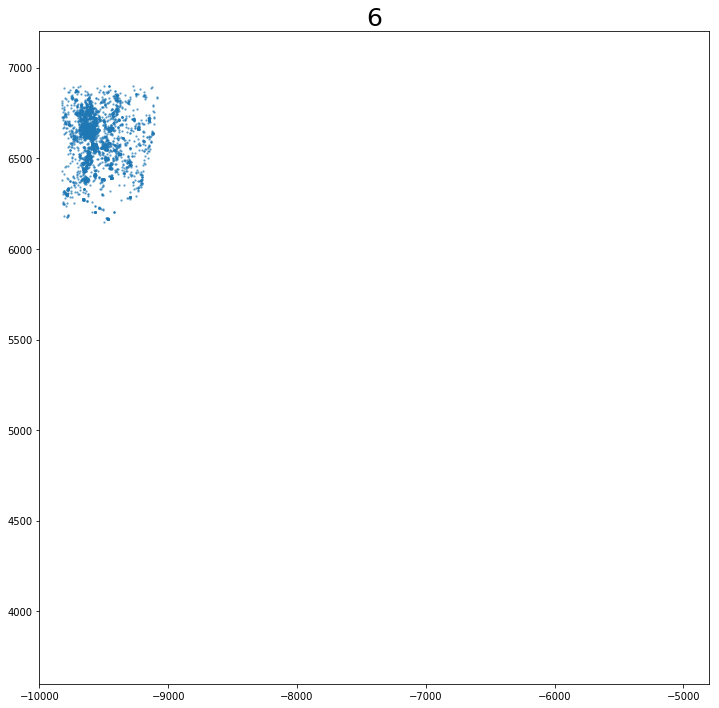

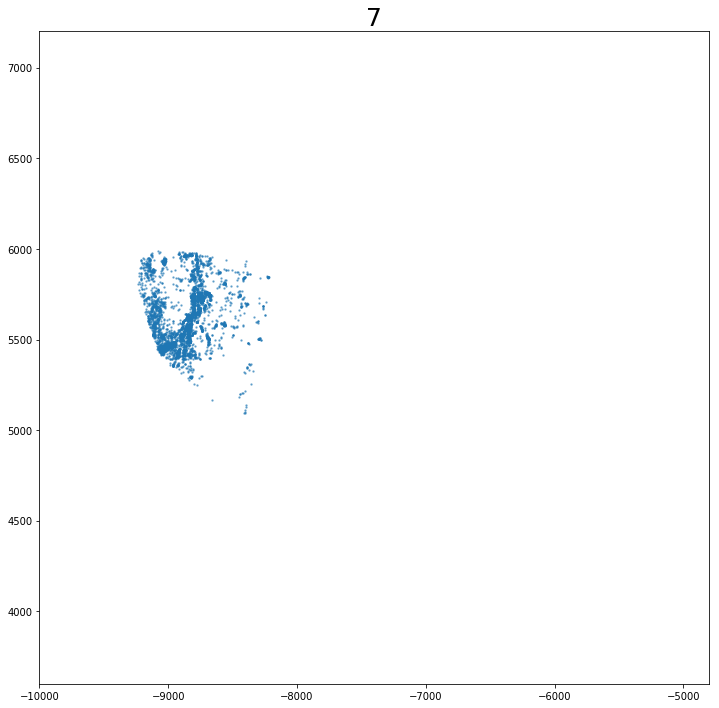

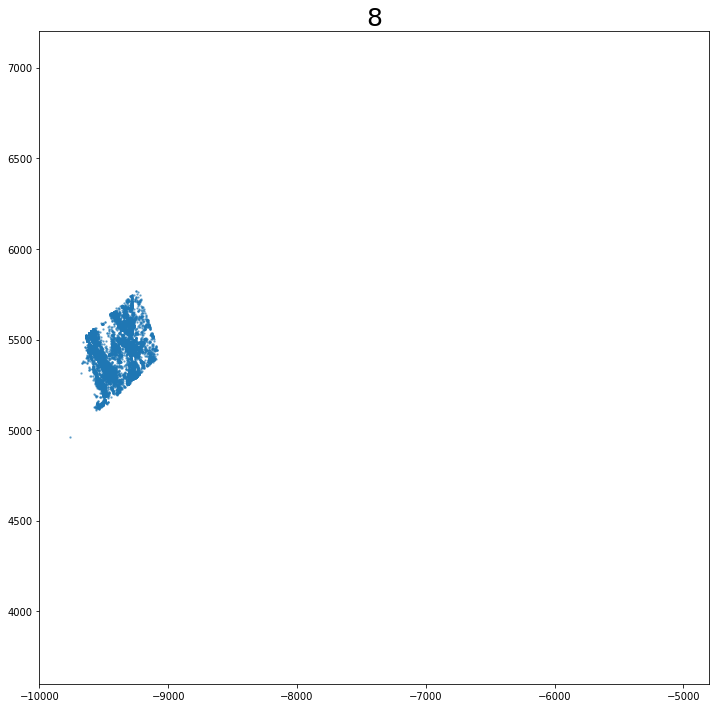

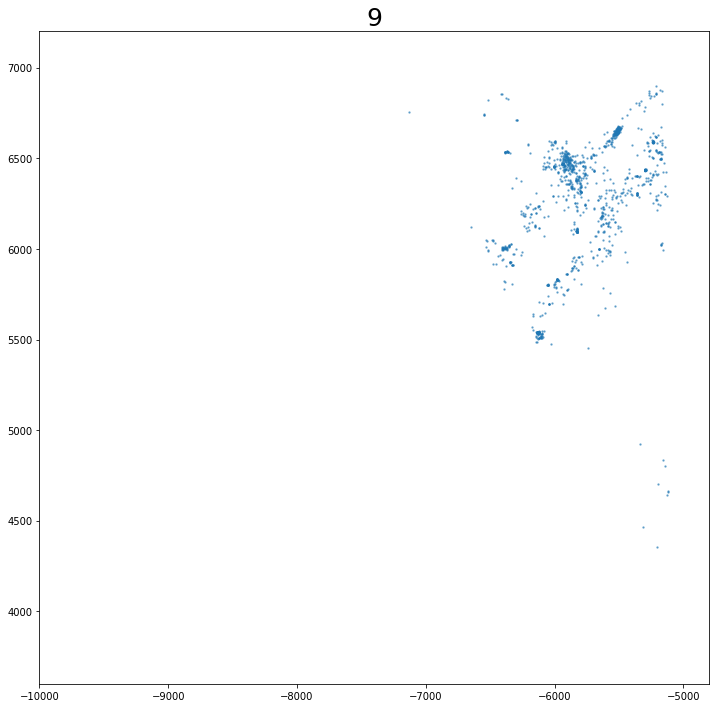

In [33]:
fig = plt.figure(figsize=(8, 8))

#plt.scatter(plane_USA[np.where(predictions_K==-1), 0], plane_USA[np.where(predictions_K==-1), 1], s=1, c="k", alpha=0.25)

for i in np.unique(predictions_K):
    fig = plt.figure(figsize=(12, 12))
    plt.title(str(i), fontsize=25)
    plt.scatter(plane_USA[np.where(predictions_K==i), 0], plane_USA[np.where(predictions_K==i), 1], alpha=0.5, s=2)
    plt.ylim([3600, 7200])
    plt.xlim([-10000, -4800])
    plt.show()

#### Deciding to merge following clusters:

Group 0: 0, 2, 4, 8

Group 1: 1

Group 2: 5

Group 3: 3, 7

Group 4: 6

Group 5: 9

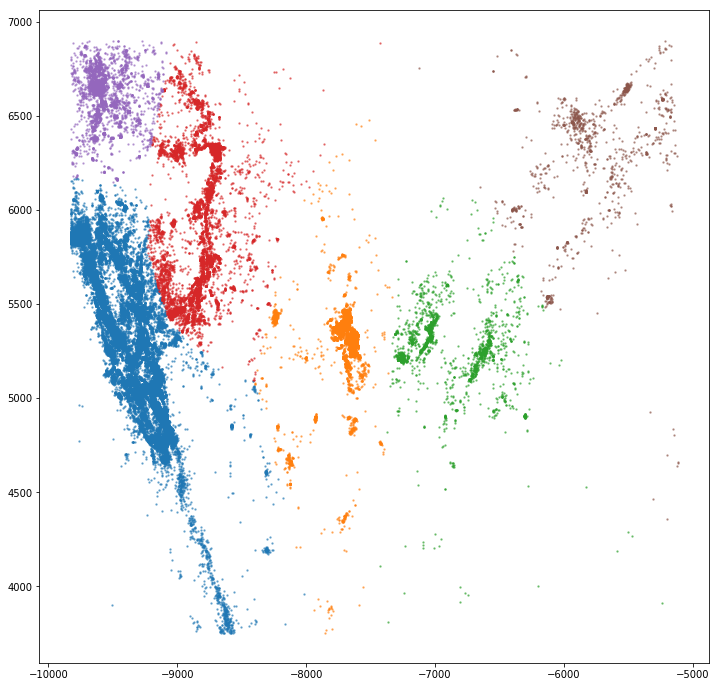

[0 1 2 3 4 5]


In [34]:
predictions_K_merge = np.array(predictions_K)

# merging 0, 2, 4, 8
predictions_K_merge[predictions_K_merge == 2] = 0
predictions_K_merge[predictions_K_merge == 4] = 0
predictions_K_merge[predictions_K_merge == 8] = 0

# merging 3, 7
predictions_K_merge[predictions_K_merge == 7] = 3

# adjusting the order of the modified labels
predictions_K_merge[predictions_K_merge == 1] = 1
predictions_K_merge[predictions_K_merge == 5] = 2
predictions_K_merge[predictions_K_merge == 6] = 4
predictions_K_merge[predictions_K_merge == 9] = 5


fig = plt.figure(figsize=(12, 12))

#plt.scatter(plane_USA[np.where(predictions_K==-1), 0], plane_USA[np.where(predictions_K==-1), 1], s=1, c="k", alpha=0.25)

for i in np.unique(predictions_K_merge):
    plt.scatter(plane_USA[np.where(predictions_K_merge==i), 0], plane_USA[np.where(predictions_K_merge==i), 1], alpha=0.5, s=2)

plt.title("Flattened and clustered USA data", fontsize=20)
plt.xlabel("x [a.u.]")
plt.ylabel("y [a.u.]")
plt.show()

print(np.unique(predictions_K_merge))

(No need to save results to file because we set the seed of K-means)

### Utility function

In [35]:
def dist2D(x1,x2,y1,y2):
    '''
        A simple euclidean utility
    '''
    return np.sqrt(np.square(x1-x2)+np.square(y1-y2))

def create_data(data, pad=0.125, N=100):
    '''
        Takes 'data' as input, and proceeds to create a spatial grid with respect to which perform the predictions
        the nn was trained to do. Choose 'pad' as to adjust the amount of space to the sides we are willing
        to explore (as a precentage), and choose 'N' as to select how many prediction points per length unit.
        
    '''
    # min and max of the xs and ys
    max_x = np.amax(data[:,2])
    min_x = np.amin(data[:,2])
    max_y = np.amax(data[:,3])
    min_y = np.amin(data[:,3])
    
    # determining the size of the padding, as to allow predictions outside the rectangle defined by the data
    pad_x = np.absolute(max_x-min_x)*(pad)
    pad_y = np.absolute(max_y-min_y)*(pad)
    
    # number of points over which to predict in x and y
    num_x = int(N*pad_x/pad)
    num_y = int(N*pad_y/pad)
    
    # the positions of the centers in x and y
    x_cent = np.linspace(min_x-pad_x, max_x+pad_x, num_x)
    y_cent = np.linspace(min_y-pad_y, max_y+pad_y, num_y)
    
    # creating a meshgrid; these are two matrices, one for the xs and one for the ys
    xy1, xy2 = np.meshgrid(x_cent, y_cent)

    # superimposing the two matrices and then "flattening" them. Now, each entry denotes one unique pair of coordinates
    centers = np.dstack(xy1, xy2).reshape((num_x*num_y,2))
    
    # the list containing the ready-to-be-fed data
    data_to_predict = []

    #putting the data inside
    for idx in range(num_x*num_y):

        # for each of the centers, compute the distance of each point
        dists = np.array([dist2D( centers[idx,0], data[i,2], centers[idx,1], data[i,3] ) 
                          for i in range(len(data))])

        # using a minmaxscaler in order to normalize the distances
        scaler = MinMaxScaler()
        dists = scaler.fit_transform(dists)
        # data[:,1] should be MAGNITUDE: to check
        data_to_predict.append([dists, data[:,1]])
    
    # here you are
    return data_to_predict

## Scaler

In [36]:
# just use MinMaxScaler imported from sklearn with default values
MinMaxScaler

sklearn.preprocessing.data.MinMaxScaler

### Working with clusters

In [37]:
# adding the column of labels
df['cluster']=predictions_K_merge

df_fin = df[['time', 'mag', 'x', 'y', 'cluster']]

# N.B.: THERE MUST BE ONLY 6 LABELS (we adjusted this before)
df0=df_fin[df_fin['cluster']==0].drop(['cluster'], axis=1)
df1=df_fin[df_fin['cluster']==1].drop(['cluster'], axis=1)
df2=df_fin[df_fin['cluster']==2].drop(['cluster'], axis=1)
df3=df_fin[df_fin['cluster']==3].drop(['cluster'], axis=1)
df4=df_fin[df_fin['cluster']==4].drop(['cluster'], axis=1)
df5=df_fin[df_fin['cluster']==5].drop(['cluster'], axis=1)

### Importing library to find maxima

In [38]:
import peakutils

# "Time" window: number of samples to avoid looking for maxima after having found 1
interval = 500

### Finding maxima

In [39]:
indexes0 = peakutils.indexes(np.array(df0.iloc[:,1]), thres=0, min_dist=interval)
indexes1 = peakutils.indexes(np.array(df1.iloc[:,1]), thres=0, min_dist=interval)
indexes2 = peakutils.indexes(np.array(df2.iloc[:,1]), thres=0, min_dist=interval)
indexes3 = peakutils.indexes(np.array(df3.iloc[:,1]), thres=0, min_dist=interval)
indexes4 = peakutils.indexes(np.array(df4.iloc[:,1]), thres=0, min_dist=interval)
indexes5 = peakutils.indexes(np.array(df5.iloc[:,1]), thres=0, min_dist=interval)

### Splitting clusters into time series with mainshock as a final element

In [40]:
data0=[]
data0.append(df0.iloc[0:(indexes0[0]+1)])
for i in range(1, len(indexes0)):
    data0.append(df0.iloc [ (indexes0[i-1]+1) : (indexes0[i]+1) ] )
    
data1=[]
data1.append(df1.iloc[0:(indexes1[0]+1)])
for i in range(1, len(indexes1)):
    data1.append(df1.iloc [ (indexes1[i-1]+1) : (indexes1[i]+1) ] )
    
data2=[]
data2.append(df2.iloc[0:(indexes2[0]+1)])
for i in range(1, len(indexes2)):
    data2.append(df2.iloc [ (indexes2[i-1]+1) : (indexes2[i]+1) ] )
    
data3=[]
data3.append(df3.iloc[0:(indexes3[0]+1)])
for i in range(1, len(indexes3)):
    data3.append(df3.iloc [ (indexes3[i-1]+1) : (indexes3[i]+1) ] )
    
data4=[]
data4.append(df4.iloc[0:(indexes4[0]+1)])
for i in range(1, len(indexes4)):
    data4.append(df4.iloc [ (indexes4[i-1]+1) : (indexes4[i]+1) ] )
    
data5=[]
data5.append(df5.iloc[0:(indexes5[0]+1)])
for i in range(1, len(indexes5)):
    data5.append(df5.iloc [ (indexes5[i-1]+1) : (indexes5[i]+1) ] )

## Preparing final data

In [41]:
min_len = 20000
counter_right = 0
counter_tot = 0
data = [data0, data1, data2, data3, data4, data5]
NN_data = []
time_window = 50

for data_ele in data:
    for lista in data_ele:
        # print(l.values.shape[0])
        counter_tot += 1
        # taking a line values
        t_ar = lista.values
        # verifying that the list is long enough
        if (t_ar.shape[0] >= interval):
            counter_right += 1
            
            # saving the minimum
            if (min_len > t_ar.shape[0]):
                min_len = t_ar.shape[0]

            # initializing a index to select windows
            my_i = 0
            while (len(t_ar[(-time_window*(my_i)-1):(-time_window*(my_i+1)-1):-1]) == time_window):
                NN_data.append(t_ar[(-time_window*(my_i)-1):(-time_window*(my_i+1)-1):-1][::-1])
                my_i += 1

print("The minimum length of a snippet is:", min_len)
print("The min number of elements is:", counter_tot)
print("The number of \"correct\" elements is:", counter_right)

The minimum length of a snippet is: 501
The min number of elements is: 278
The number of "correct" elements is: 272


### Splitting time series into snippets of lenght 50 elements (49 + last to predict)

In [42]:
check = 0

for ele in NN_data:
    if len(ele) == 50:
        check+=1
print("Testing correct legnth of every \"data\" :", check, "vs", len(NN_data))

# evaluating distances w.r.t. the last element

NN_dist = []
NN_label = []
NN_magn = []
for ele in NN_data:
    X=ele[-1][2]
    Y=ele[-1][3]
    NN_dist.append(dist2D(ele[:,2][:-1], ele[:,3][:-1], X, Y))
    NN_label.append(ele[-1][1])
    NN_magn.append(ele[:,1][:-1])

print("Checking length of \"dist\" list:", len(NN_dist))
print("Checking length of \"label\" list:", len(NN_label))
print("Checking length of \"magn\" list:", len(NN_magn))

#for ele in NN_label:
#    print(ele)

#for ele in NN_magn:
#    print(len(ele))

#for ele in NN_dist:
#    print(ele)

# SCALING DISTANCES
NN_dist_scaled = []
for ind in range(len(NN_dist)):
    ele = NN_dist[ind].reshape(-1, 1)
    NN_dist_scaled.append(MinMaxScaler().fit(ele).transform(ele).T[0])
    #print(NN_dist_scaled[-1])

print("Checking length of 1 element of \"dist\" list:", len(NN_dist[0]))

Testing correct legnth of every "data" : 3620 vs 3620
Checking length of "dist" list: 3620
Checking length of "label" list: 3620
Checking length of "magn" list: 3620
Checking length of 1 element of "dist" list: 49


## Defining regression NN

In [43]:
# how many steps the LSTM can look back
n_steps = 49

n_features = 2
n_samples = 3620

model = Sequential()
# dropout = 50%
model.add(LSTM(100, activation='relu', recurrent_dropout=0.5, dropout=0.5, input_shape=(n_steps, n_features)))
#model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features, n_samples)))
#model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5, seed=123))
model.add(Dense(1, activation='relu'))

"""
inputs = Input(shape=(n_features, n_steps))
x = LSTM(100, activation='relu', recurrent_dropout=0.1, dropout=0.1)(inputs)
y = Dense(50, activation="relu")(x)
drop = Dropout(0.3)(x, training=True)
outputs = Dense(2, activation="relu")(drop)

model = Model(inputs, outputs)
"""

# using y for regression
model.compile(loss="MSE",
             optimizer='adam')
#              metrics=['accuracy'])


X = np.stack((NN_magn, NN_dist_scaled), axis=2)
#Y = np.stack((NN_label, np.zeros(len(NN_label))), axis=1)
Y = NN_label

# splitting "train" and test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

# splitting effective train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, random_state=10)

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='Embed.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
Y_val

[2.52,
 2.3,
 2.37,
 4.45,
 2.97,
 2.18,
 2.07,
 2.01,
 2.14,
 2.9,
 2.43,
 2.2,
 2.69,
 2.8,
 3.1,
 2.13,
 2.14,
 2.28,
 2.13,
 2.6,
 2.1,
 3.2,
 2.12,
 2.89,
 3.2,
 2.19,
 3.1,
 2.61,
 2.11,
 2.64,
 2.25,
 2.49,
 2.2,
 2.04,
 2.04,
 2.46,
 2.11,
 2.1,
 2.15,
 2.11,
 2.76,
 2.5,
 2.11,
 3.0,
 2.06,
 3.5,
 2.5,
 2.0,
 2.96,
 2.63,
 2.32,
 3.48,
 2.97,
 2.11,
 2.59,
 2.13,
 2.51,
 2.7,
 2.3,
 2.76,
 2.37,
 2.05,
 2.06,
 2.12,
 2.07,
 2.0,
 2.32,
 2.2,
 2.06,
 2.11,
 2.0,
 3.01,
 2.02,
 3.1,
 2.48,
 2.1,
 2.81,
 2.6,
 2.99,
 2.15,
 4.21,
 2.22,
 2.51,
 2.86,
 2.06,
 2.07,
 2.33,
 2.03,
 2.8,
 5.4,
 5.3,
 2.19,
 3.7,
 2.1,
 4.3,
 2.48,
 2.54,
 2.25,
 2.7,
 2.2,
 2.25,
 2.61,
 2.9,
 2.1,
 2.17,
 2.0,
 2.45,
 2.01,
 2.6,
 2.02,
 2.07,
 2.12,
 2.06,
 2.41,
 2.6,
 4.36,
 2.21,
 2.38,
 2.44,
 3.13,
 3.4,
 2.07,
 2.08,
 2.59,
 2.06,
 3.48,
 2.53,
 2.1,
 2.4,
 3.8,
 2.59,
 2.19,
 2.34,
 2.21,
 2.54,
 2.41,
 2.39,
 2.13,
 2.07,
 2.41,
 2.2,
 2.98,
 2.96,
 2.26,
 2.23,
 2.33,
 2.77,
 2.44,
 2.6,
 

### Verifying the length of the train, validation and test

In [45]:
print("Length of train:\t", len(X_train) )
print("Length of validaton:\t", len(X_val) )
print("Length of test:\t\t", len(X_test) )

print("Testing lengths:\t", int(len(X_train)+len(X_val)+len(X_test)), "vs", len(X) )

Length of train:	 2932
Length of validaton:	 326
Length of test:		 362
Testing lengths:	 3620 vs 3620


 ## Training NN

In [46]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)
#, restore_best_weights=True

# batch size = number of samples used to evaluate the gradient (arbitrary, default 32)
history = model.fit(X_train, Y_train, epochs=1000, verbose=1, steps_per_epoch=10,
                    validation_data=(X_val, Y_val), callbacks=[early_stop], validation_steps=10)

score = model.evaluate(X_test, Y_test, batch_size=16)

Instructions for updating:
Use tf.cast instead.
Train on 2932 samples, validate on 326 samples
Epoch 1/1000
10/10 [==============================] - 9s 938ms/step - loss: 10.0814 - val_loss: 6.4823
Epoch 2/1000
10/10 [==============================] - 7s 726ms/step - loss: 6.1811 - val_loss: 5.8584
Epoch 3/1000
10/10 [==============================] - 7s 689ms/step - loss: 5.4117 - val_loss: 5.4524
Epoch 4/1000
10/10 [==============================] - 7s 696ms/step - loss: 6.3325 - val_loss: 5.2426
Epoch 5/1000
10/10 [==============================] - 10s 1s/step - loss: 6.5681 - val_loss: 4.9510
Epoch 6/1000
10/10 [==============================] - 8s 786ms/step - loss: 4.5868 - val_loss: 4.6326
Epoch 7/1000
10/10 [==============================] - 7s 710ms/step - loss: 4.4584 - val_loss: 4.3797
Epoch 8/1000
10/10 [==============================] - 7s 727ms/step - loss: 4.1315 - val_loss: 4.1234
Epoch 9/1000
10/10 [==============================] - 7s 694ms/step - loss: 5.4880 - val_l

## Verifying predictions

In [47]:
Y_pred = model.predict(X_test, )

print("Max of predictions is:", max(Y_pred[:,0]), end="\n\n")

for i in range(len(Y_pred)):
    #if Y_test[i] > 5:
    print("--->\t", Y_pred[i][0], "\tvs\t", Y_test[i])
    if Y_pred[i] > 5:
        print(">>>>\t", Y_pred[i][0], "\tvs\t", Y_test[i])

Max of predictions is: 1.9240364

--->	 1.3885612 	vs	 3.96
--->	 1.5557799 	vs	 2.5
--->	 1.585379 	vs	 2.23
--->	 1.6606988 	vs	 2.0
--->	 1.6232185 	vs	 2.7
--->	 1.4210428 	vs	 2.02
--->	 1.582193 	vs	 2.4
--->	 1.4420346 	vs	 2.1
--->	 1.4818761 	vs	 2.1
--->	 1.5925454 	vs	 2.0
--->	 1.3572996 	vs	 2.4
--->	 1.4966884 	vs	 2.34
--->	 1.4543921 	vs	 2.21
--->	 1.6275645 	vs	 2.4
--->	 1.4702421 	vs	 3.02
--->	 1.5679384 	vs	 2.43
--->	 1.5849892 	vs	 2.29
--->	 1.5709532 	vs	 2.1
--->	 1.6176053 	vs	 2.8
--->	 1.4152764 	vs	 2.13
--->	 1.6223317 	vs	 2.23
--->	 1.4462155 	vs	 2.4
--->	 1.587505 	vs	 2.2
--->	 1.4938678 	vs	 2.48
--->	 1.6254873 	vs	 2.25
--->	 1.6910938 	vs	 3.6
--->	 1.597736 	vs	 2.8
--->	 1.6227919 	vs	 2.9
--->	 1.6162559 	vs	 2.4
--->	 1.4759382 	vs	 2.17
--->	 1.4021498 	vs	 2.4
--->	 1.4656013 	vs	 2.01
--->	 1.3745724 	vs	 2.35
--->	 1.5485462 	vs	 2.07
--->	 1.446532 	vs	 2.19
--->	 1.6414372 	vs	 2.25
--->	 1.6793331 	vs	 2.88
--->	 1.4965241 	vs	 5.7
--

## Trying to use custom loss

### Defining a custom loss

Out custom loss is though to be 0 when the prediction is correct, exponentially small in case of false negative (the allarm is thrown while there are no earthquakes) and exponentially large in case of false positive (the earthquakes are not predicted but happen).

In [48]:
def custom_loss():

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        return (y_true-y_pred)**2/(1+tf.math.exp(-10*(y_true-4)))

    # Return a function
    return loss

## Re-defining NN to use custom loss

In [87]:
# how many steps the LSTM can look back
n_steps = 49

n_features = 2
n_samples = 3620

model = Sequential()
# dropout = 50%
model.add(LSTM(100, activation='relu', recurrent_dropout=0.5, dropout=0.5, input_shape=(n_steps, n_features)))
#model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features, n_samples)))
#model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5, seed=123))
model.add(Dense(1, activation='relu'))

"""
inputs = Input(shape=(n_features, n_steps))
x = LSTM(100, activation='relu', recurrent_dropout=0.1, dropout=0.1)(inputs)
y = Dense(50, activation="relu")(x)
drop = Dropout(0.3)(x, training=True)
outputs = Dense(2, activation="relu")(drop)

model = Model(inputs, outputs)
"""

# using y for regression
model.compile(loss=custom_loss(),
             optimizer='adam')
#              metrics=['accuracy'])


X = np.stack((NN_magn, NN_dist_scaled), axis=2)
#Y = np.stack((NN_label, np.zeros(len(NN_label))), axis=1)
Y = NN_label

# splitting "train" and test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

# splitting effective train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, random_state=10)

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='Embed.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________
None


### Verifying the length of the train, validation and test

In [50]:
print("Length of train:\t", len(X_train) )
print("Length of validaton:\t", len(X_val) )
print("Length of test:\t\t", len(X_test) )

print("Testing lengths:\t", int(len(X_train)+len(X_val)+len(X_test)), "vs", len(X) )

Length of train:	 2932
Length of validaton:	 326
Length of test:		 362
Testing lengths:	 3620 vs 3620


## Training NN

In [51]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)
#, restore_best_weights=True

# batch size = number of samples used to evaluate the gradient (arbitrary, default 32)
history = model.fit(X_train, Y_train, epochs=1000, verbose=1, steps_per_epoch=10,
                    validation_data=(X_val, Y_val), callbacks=[early_stop], validation_steps=10)

score = model.evaluate(X_test, Y_test, batch_size=16)

Train on 2932 samples, validate on 326 samples
Epoch 1/1000
10/10 [==============================] - 8s 847ms/step - loss: 2.1827 - val_loss: 1.4089
Epoch 2/1000
10/10 [==============================] - 7s 725ms/step - loss: 1.7654 - val_loss: 1.3996
Epoch 3/1000
10/10 [==============================] - 7s 725ms/step - loss: 1.6988 - val_loss: 1.3171
Epoch 4/1000
10/10 [==============================] - 7s 711ms/step - loss: 1524.2610 - val_loss: 1.3327
Epoch 5/1000
10/10 [==============================] - 7s 690ms/step - loss: 4.8513 - val_loss: 1.3571
Epoch 6/1000
10/10 [==============================] - 7s 714ms/step - loss: 1329.8097 - val_loss: 1.3678
Epoch 7/1000
10/10 [==============================] - 7s 741ms/step - loss: 1.6682 - val_loss: 1.3649
Epoch 8/1000
10/10 [==============================] - 7s 720ms/step - loss: 1.6691 - val_loss: 1.3533
Epoch 9/1000
10/10 [==============================] - 7s 693ms/step - loss: 1.6472 - val_loss: 1.3384
Epoch 10/1000
10/10 [========

10/10 [==============================] - 7s 712ms/step - loss: 0.7873 - val_loss: 0.5373
Epoch 81/1000
10/10 [==============================] - 8s 761ms/step - loss: 0.7902 - val_loss: 0.5321
Epoch 82/1000
10/10 [==============================] - 8s 776ms/step - loss: 0.7752 - val_loss: 0.5284
Epoch 83/1000
10/10 [==============================] - 7s 745ms/step - loss: 0.7665 - val_loss: 0.5238
Epoch 84/1000
10/10 [==============================] - 7s 722ms/step - loss: 0.7680 - val_loss: 0.5182
Epoch 85/1000
10/10 [==============================] - 7s 735ms/step - loss: 0.7543 - val_loss: 0.5122
Epoch 86/1000
10/10 [==============================] - 7s 730ms/step - loss: 0.7673 - val_loss: 0.5085
Epoch 87/1000
10/10 [==============================] - 7s 735ms/step - loss: 0.7616 - val_loss: 0.5086
Epoch 88/1000
10/10 [==============================] - 7s 746ms/step - loss: 0.7520 - val_loss: 0.5046
Epoch 89/1000
10/10 [==============================] - 7s 741ms/step - loss: 0.7690 - v

## Verifying predictions

In [52]:
Y_pred = model.predict(X_test, )

print("Max of predictions is:", max(Y_pred[:,0]), end="\n\n")

for i in range(len(Y_pred)):
    #if Y_test[i] > 5:
    print("--->\t", Y_pred[i][0], "\tvs\t", Y_test[i])
    if Y_pred[i] > 5:
        print(">>>>\t", Y_pred[i][0], "\tvs\t", Y_test[i])

Max of predictions is: 1.9434493

--->	 1.4567027 	vs	 3.96
--->	 1.5929854 	vs	 2.5
--->	 1.6320498 	vs	 2.23
--->	 1.68239 	vs	 2.0
--->	 1.6473702 	vs	 2.7
--->	 1.4795277 	vs	 2.02
--->	 1.6325748 	vs	 2.4
--->	 1.5073097 	vs	 2.1
--->	 1.5269365 	vs	 2.1
--->	 1.6137767 	vs	 2.0
--->	 1.436131 	vs	 2.4
--->	 1.5545828 	vs	 2.34
--->	 1.5227177 	vs	 2.21
--->	 1.6687355 	vs	 2.4
--->	 1.5366783 	vs	 3.02
--->	 1.6147878 	vs	 2.43
--->	 1.6376448 	vs	 2.29
--->	 1.6143887 	vs	 2.1
--->	 1.6625987 	vs	 2.8
--->	 1.4770207 	vs	 2.13
--->	 1.6596124 	vs	 2.23
--->	 1.4809375 	vs	 2.4
--->	 1.6318876 	vs	 2.2
--->	 1.5517979 	vs	 2.48
--->	 1.6605234 	vs	 2.25
--->	 1.7256143 	vs	 3.6
--->	 1.6363602 	vs	 2.8
--->	 1.6705229 	vs	 2.9
--->	 1.6410627 	vs	 2.4
--->	 1.5315748 	vs	 2.17
--->	 1.4757142 	vs	 2.4
--->	 1.5354215 	vs	 2.01
--->	 1.4482045 	vs	 2.35
--->	 1.6039851 	vs	 2.07
--->	 1.5120885 	vs	 2.19
--->	 1.6769431 	vs	 2.25
--->	 1.6935296 	vs	 2.88
--->	 1.5510149 	vs	 5.7


## Trying MLP Regressor

In [88]:
my_MLP_r = nn.MLPRegressor(hidden_layer_sizes=150, activation="relu", early_stopping=True,
                         validation_fraction=0.1, random_state=123 )

In [89]:
# these are only the magnitudes
X_train_val[:,:,0]

array([[2.07, 2.31, 2.5 , ..., 2.43, 2.74, 2.65],
       [2.61, 2.22, 2.18, ..., 2.14, 2.23, 2.12],
       [2.23, 2.13, 2.5 , ..., 2.02, 2.88, 3.06],
       ...,
       [2.5 , 2.7 , 2.39, ..., 3.05, 2.26, 3.7 ],
       [2.49, 2.68, 2.06, ..., 2.51, 3.18, 2.  ],
       [2.09, 2.33, 3.17, ..., 2.42, 2.09, 2.38]])

In [90]:
my_MLP_r.fit(X_train_val[:,:,0], Y_train_val)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=150, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=123, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [92]:
my_pred = my_MLP_r.predict(X_test[:,:,0])

for i in range(len(my_pred)):
    if Y_test[i] > 5:
        print(my_pred[i], "\tvs\t", Y_test[i])

2.805316852987358 	vs	 5.7
2.5985521887040135 	vs	 5.6
2.6261865530655517 	vs	 5.4
2.869829285944818 	vs	 6.57
2.4788235199959376 	vs	 5.1
2.7423365578179446 	vs	 5.3
2.3768847081731823 	vs	 5.7
2.536206607496683 	vs	 5.3
3.0557737800296008 	vs	 5.08
2.5509528359583657 	vs	 5.7
2.619453564663996 	vs	 6.1
3.069581855260243 	vs	 5.5
2.7182195809224585 	vs	 5.9


## Trying to predict with labels (not with regression; still using custom loss)

In [53]:
def custom_loss():
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        
        return (y_true-y_pred)**2*tf.math.exp(5*(y_true-y_pred))

    # Return a function
    return loss

In [96]:
# how many steps the LSTM can look back
n_steps = 49

n_features = 2
n_samples = 3620

model = Sequential()
# dropout = 50%
# model.add(LSTM(100, activation='relu', recurrent_dropout=0.3, dropout=0.3, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.5))
#model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features, n_samples)))
#model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5, seed=123))
model.add(Dense(1, activation='sigmoid'))

"""
inputs = Input(shape=(n_features, n_steps))
x = LSTM(100, activation='relu', recurrent_dropout=0.1, dropout=0.1)(inputs)
y = Dense(50, activation="relu")(x)
drop = Dropout(0.3)(x, training=True)
outputs = Dense(2, activation="relu")(drop)

model = Model(inputs, outputs)
"""

# using y for regression
# model.compile(loss=custom_loss(),
#              optimizer='adam')

#              metrics=['accuracy'])

# using labels for classifications
model.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['accuracy'])

X = np.stack((NN_magn, NN_dist_scaled), axis=2)
#Y = np.stack((NN_label, np.zeros(len(NN_label))), axis=1)
Y = np.array(NN_label)
Y_labels = np.array(Y)

# trying using labels
Y_labels[Y>4.5] = 1
Y_labels[Y<=4.5] = 0

# splitting "train" and test set
# X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y_labels, test_size=0.1, random_state=1)

# splitting effective train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, random_state=10)

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='Embed.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________
None


### Training with labels

In [55]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)
#, restore_best_weights=True

# batch size = number of samples used to evaluate the gradient (arbitrary, default 32)
history = model.fit(X_train, Y_train, epochs=1000, verbose=1, steps_per_epoch=10,
                    validation_data=(X_val, Y_val), callbacks=[early_stop], validation_steps=10)

score = model.evaluate(X_test, Y_test, batch_size=16)

Train on 2932 samples, validate on 326 samples
Epoch 1/1000
10/10 [==============================] - 10s 1s/step - loss: 0.4511 - acc: 0.9324 - val_loss: 0.2545 - val_acc: 0.9632
Epoch 2/1000
10/10 [==============================] - 8s 785ms/step - loss: 0.2717 - acc: 0.9417 - val_loss: 0.2209 - val_acc: 0.9632
Epoch 3/1000
10/10 [==============================] - 7s 671ms/step - loss: 0.2520 - acc: 0.9417 - val_loss: 0.1980 - val_acc: 0.9632
Epoch 4/1000
10/10 [==============================] - 6s 646ms/step - loss: 0.2435 - acc: 0.9416 - val_loss: 0.1760 - val_acc: 0.9632
Epoch 5/1000
10/10 [==============================] - 6s 649ms/step - loss: 0.2403 - acc: 0.9417 - val_loss: 0.1690 - val_acc: 0.9632
Epoch 6/1000
10/10 [==============================] - 7s 674ms/step - loss: 0.2380 - acc: 0.9417 - val_loss: 0.1703 - val_acc: 0.9632
Epoch 7/1000
10/10 [==============================] - 7s 660ms/step - loss: 0.2379 - acc: 0.9417 - val_loss: 0.1647 - val_acc: 0.9632
Epoch 8/1000
10/1

In [56]:
Y_pred = model.predict(X_test, )

print("Max of predictions is:", max(Y_pred[:,0]), end="\n\n")

for i in range(len(Y_pred)):
    if Y_test[i] == 1:
        print("--->\t", Y_pred[i][0], "\tvs\t", Y_test[i])
    if Y_pred[i] > 5:
        print(">>>>\t", Y_pred[i][0], "\tvs\t", Y_test[i])

Max of predictions is: 1.0

--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0
--->	 1.0 	vs	 1.0


## Saving model to file

In [57]:
# serialize model to JSON
#model_json = model.to_json()
#with open("model_2324_28-5-19.json", "w") as json_file:
#    json_file.write(model_json)

# serialize weights to HDF5
#model.save_weights("model_2324_28-5-19.h5")
#print("Saved model to disk")

## Trying MLP Classifier

In [97]:
my_MLP_c = nn.MLPClassifier(hidden_layer_sizes=150, activation="relu", early_stopping=True,
                         validation_fraction=0.1, random_state=123 )

In [98]:
# these are only the magnitudes
X_train_val[:,:,0]

array([[2.07, 2.31, 2.5 , ..., 2.43, 2.74, 2.65],
       [2.61, 2.22, 2.18, ..., 2.14, 2.23, 2.12],
       [2.23, 2.13, 2.5 , ..., 2.02, 2.88, 3.06],
       ...,
       [2.5 , 2.7 , 2.39, ..., 3.05, 2.26, 3.7 ],
       [2.49, 2.68, 2.06, ..., 2.51, 3.18, 2.  ],
       [2.09, 2.33, 3.17, ..., 2.42, 2.09, 2.38]])

In [99]:
np.unique(Y_train_val[:])

array([0., 1.])

In [100]:
my_MLP_c.fit(X_train_val[:,:,0], Y_train_val)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=150, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=123, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### Making predictions

In [101]:
my_pred = my_MLP_c.predict(X_test[:,:,0])

for i in range(len(my_pred)):
    if Y_test[i] == 1:
        print(my_pred[i], "\tvs\t", Y_test[i])

0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0
0.0 	vs	 1.0


## Trying gaussian processes

### Repeating some steps

In [ ]:
import peakutils

interval = 500

In [ ]:
# adding the column of labels
df['cluster']=predictions_K_merge

df_fin = df[['time', 'mag', 'x', 'y', 'cluster']]

data_NN = []

# N.B.: THERE MUST BE ONLY 6 LABELS (we adjusted this before)
for i in predictions:
    data_NN.append(df_fin[df_fin['cluster']==i].drop(['cluster'], axis=1))

In [ ]:
indexes_util = []

for i in predictions:
    indexes_util.append(peakutils.indexes(np.array(data_NN[i].iloc[:,1]), thres=0, min_dist=interval))

In [ ]:
data0=[]
data0.append(df0.iloc[0:(indexes0[0]+1)])
for i in range(1, len(indexes0)):
    data0.append(df0.iloc [ (indexes0[i-1]+1) : (indexes0[i]+1) ] )

for i in range(len(data_NN)):
    for j in range(len())

data1=[]
data1.append(df1.iloc[0:(indexes1[0]+1)])
for i in range(1, len(indexes1)):
    data1.append(df1.iloc [ (indexes1[i-1]+1) : (indexes1[i]+1) ] )
    
data2=[]
data2.append(df2.iloc[0:(indexes2[0]+1)])
for i in range(1, len(indexes2)):
    data2.append(df2.iloc [ (indexes2[i-1]+1) : (indexes2[i]+1) ] )
    
data3=[]
data3.append(df3.iloc[0:(indexes3[0]+1)])
for i in range(1, len(indexes3)):
    data3.append(df3.iloc [ (indexes3[i-1]+1) : (indexes3[i]+1) ] )
    
data4=[]
data4.append(df4.iloc[0:(indexes4[0]+1)])
for i in range(1, len(indexes4)):
    data4.append(df4.iloc [ (indexes4[i-1]+1) : (indexes4[i]+1) ] )
    
data5=[]
data5.append(df5.iloc[0:(indexes5[0]+1)])
for i in range(1, len(indexes5)):
    data5.append(df5.iloc [ (indexes5[i-1]+1) : (indexes5[i]+1) ] )

## Trying gaussian processes

In [19]:
from sklearn import gaussian_process
from scipy.spatial import distance

In [20]:
df1

,time,mag,x,y
583,4.555177e+06,3.5,-7815.492654,5694.555327
1223,8.967012e+06,3.6,-7708.717614,4355.453651
1735,1.212127e+07,3.4,-7904.576690,6047.743914
2801,1.917665e+07,3.6,-7908.350771,3934.856977
3100,2.119675e+07,2.9,-8377.909344,5148.557803
3380,2.326665e+07,4.6,-8106.490022,4819.274591
4379,3.000909e+07,2.2,-7679.232606,5143.136316
4509,3.112160e+07,2.7,-7823.355323,5682.360396
4605,3.156253e+07,2.3,-7587.475263,4518.588976
4705,3.229188e+07,3.1,-8237.953842,5464.305140


Idea: matrix of distances to evaluate the typical scale lenght

Problem: too many computations...

In [21]:
# my_matrix = distance.cdist(df1["x"], df1["y"])

In [22]:
df1_scaled = df1.values.copy()
my_scaler = StandardScaler()

for i in range(4):
    my_scaler.fit(df1_scaled[:,i].reshape(-1, 1))
    df1_scaled[:,i] = my_scaler.transform(df1_scaled[:,i].reshape(1, -1))

my_y = df1["mag"].values
my_y

array([3.5, 3.6, 3.4, ..., 2.3, 2.9, 2.7])

Idea: normalizing data

Idea: evaluating consecutive distances

In [23]:
my_lengths = []
my_t = 1000
my_lengths.append(np.mean(np.abs(np.ediff1d(df1_scaled[:,0][-my_t:-10])))/10000)
#my_lengths.append(np.mean(np.abs(np.ediff1d(df1["mag"].tail(my_t)))))
my_lengths.append(np.mean(np.abs(np.ediff1d(df1_scaled[:,2][-my_t:-10]))))
my_lengths.append(np.mean(np.abs(np.ediff1d(df1_scaled[:,3][-my_t:-10])))/2)

my_lengths

[3.413229925368401e-08, 0.9833740187882823, 0.6552879832416075]

In [24]:
np.array([df1["time"].values[-my_t:-10], df1["x"].values[-my_t:-10], df1["y"].values[-my_t:-10]]).T.shape

(990, 3)

In [25]:
df1["y"].values[-my_t:-10].shape

(990,)

### Launching many gaussian processes for $\nu \in \left[0.1, 0.2, ..., 1.4, 1.5 \right]$  

In [26]:
ind = np.array([i for i in range(-10, 0)])
#print(ind)

for nu_ in np.linspace(0.1, 1.5, 15):
    my_kern = gaussian_process.kernels.Matern(length_scale=my_lengths, nu=nu_) \
                 + gaussian_process.kernels.WhiteKernel(noise_level=0.05)
    my_gpr = gaussian_process.GaussianProcessRegressor(kernel=my_kern).fit(X=np.array([df1["time"].values[-my_t:-10],
                                   df1["x"].values[-my_t:-10],
                                   df1["y"].values[-my_t:-10]]).T ,
                                    y=df1["mag"].values[-my_t:-10])

    # y_pred = my_gpr.predict(X=np.array([df1["time"].values[ind], df1["x"].values[ind], df1["y"].values[ind]]).reshape(1,-1))
    y_pred = my_gpr.predict(X=np.array([df1["time"].values[ind], df1["x"].values[ind], df1["y"].values[ind]]).T)
    y_series = df1["mag"].values[ind]

    for i,ele in enumerate(y_pred):
        print("--->", ele, "\tvs\t", y_series[i])

[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.7
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.5
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.9
---> 0.0 	vs	 2.7
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.7
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.5
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.9
---> 0.0 	vs	 2.7
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.7
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.5
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.9
---> 0.0 	vs	 2.7
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.7
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.5
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.9
---> 0.0 	vs	 2.7


/home/tommaso/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: divide by zero encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/home/tommaso/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.7
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.5
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.9
---> 0.0 	vs	 2.7
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.7
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.5
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.9
---> 0.0 	vs	 2.7
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.7
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.5
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.9
---> 0.0 	vs	 2.7
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.7
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.5
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.6
---> 0.0 	vs	 2.3
---> 0.0 	vs	 2.9
---> 0.0 	vs	 2.7
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.2
---> 0.0 	vs	 2.7
---> 0.0 	vs	 2.